In [1]:
!pip -q install torch torchvision matplotlib tqdm

##**Imports & Helper Functions**

In [2]:
# Cell 1 — Install & imports + helpers
!pip -q install torch torchvision matplotlib tqdm scikit-learn

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", DEVICE)

SAVE_DIR = 'vae_runs'
os.makedirs(SAVE_DIR, exist_ok=True)

def show_grid(tensor, nrow=8, title=None):
    """Show a grid of images (tensor shape BxCxHxW)"""
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, pad_value=1.0)
    plt.figure(figsize=(6,6))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.imshow(grid.permute(1,2,0).cpu())
    plt.show()


Device: cuda


## **Load Dataset**

In [3]:
# Cell 2 — Dataset & DataLoaders
transform = transforms.Compose([
    transforms.ToTensor(),  # Fashion-MNIST is 0..1 grayscale
])

train_ds = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
val_ds   = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

batch_size = 128

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=0, pin_memory=True)

label_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
print("Train size:", len(train_ds), "Val size:", len(val_ds))


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.72MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 20.7MB/s]

Train size: 60000 Val size: 10000


## **Encoder, Decoder, and VAE**

In [4]:
# Cell 3 — VAE model (with encode/decode helpers)
class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim

        # encoder: conv-based (keeps earlier architecture idea) -> flatten -> fc
        self.enc_net = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 28->14
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1), # 14->7
            nn.ReLU(True),
            nn.Flatten()
        )
        self.enc_feat_dim = 64 * 7 * 7
        self.fc_mu = nn.Linear(self.enc_feat_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_feat_dim, latent_dim)

        # decoder: fc -> convtranspose
        self.fc_dec = nn.Linear(latent_dim, self.enc_feat_dim)
        self.dec_net = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # 7->14
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),  # 14->28
            nn.Sigmoid()  # output in [0,1]
        )

    def encode(self, x):
        h = self.enc_net(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 64, 7, 7)
        x_rec = self.dec_net(h)
        return x_rec

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_rec = self.decode(z)
        return x_rec, mu, logvar

    @torch.no_grad()
    def sample(self, n=64, device='cpu'):
        z = torch.randn(n, self.latent_dim, device=device)
        imgs = self.decode(z)
        return imgs

# instantiate
latent_dim = 16
model = VAE(latent_dim=latent_dim).to(DEVICE)
print(model)


VAE(
  (enc_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=3136, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=16, bias=True)
  (fc_dec): Linear(in_features=16, out_features=3136, bias=True)
  (dec_net): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)


## **Loss Function (ELBO) + Training Loop**

In [5]:
# Cell 4 — Loss (ELBO) and training loop
def elbo_loss(x, x_rec, mu, logvar):
    # x and x_rec in [0,1]; use BCE per sample (sum) then mean over batch
    recon = F.binary_cross_entropy(x_rec, x, reduction='sum') / x.size(0)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon + kl, recon, kl

opt = torch.optim.Adam(model.parameters(), lr=2e-3)
epochs = 10  # quick; increase later to 20
SAVE_DIR = 'vae_runs'
os.makedirs(SAVE_DIR, exist_ok=True)

fixed_batch, _ = next(iter(val_loader))
fixed_batch = fixed_batch.to(DEVICE)

for ep in range(1, epochs+1):
    model.train()
    train_loss = train_recon = train_kl = 0.0
    for x, _ in tqdm(train_loader, desc=f"Epoch {ep}/{epochs}"):
        x = x.to(DEVICE)
        x_rec, mu, logvar = model(x)
        loss, recon, kl = elbo_loss(x, x_rec, mu, logvar)

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item() * x.size(0)
        train_recon += recon.item() * x.size(0)
        train_kl += kl.item() * x.size(0)

    n = len(train_loader.dataset)
    train_loss /= n; train_recon /= n; train_kl /= n

    # Validation on fixed batch
    model.eval()
    with torch.no_grad():
        x = fixed_batch
        x_rec, mu, logvar = model(x)
        val_loss, val_recon, val_kl = elbo_loss(x, x_rec, mu, logvar)

    # Save images
    with torch.no_grad():
        samples = model.sample(64, device=DEVICE)
        utils.save_image(samples, f"{SAVE_DIR}/samples_ep{ep:02d}.png", nrow=8, normalize=True)
        recons = x_rec
        comparison = torch.cat([x[:8].cpu(), recons[:8].cpu()])
        utils.save_image(comparison, f"{SAVE_DIR}/recon_ep{ep:02d}.png", nrow=8, normalize=True)

    print(f"Epoch {ep:02d} | train ELBO {train_loss:.3f} (recon {train_recon:.3f}, kl {train_kl:.3f}) | "
          f"val ELBO {val_loss:.3f} (recon {val_recon:.3f}, kl {val_kl:.3f})")


Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 01 | train ELBO 274.199 (recon 256.515, kl 17.684) | val ELBO 248.610 (recon 229.879, kl 18.731)


Epoch 2/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 02 | train ELBO 249.034 (recon 231.306, kl 17.728) | val ELBO 243.934 (recon 227.035, kl 16.899)


Epoch 3/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 03 | train ELBO 246.045 (recon 228.417, kl 17.628) | val ELBO 241.470 (recon 224.388, kl 17.082)


Epoch 4/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 04 | train ELBO 244.517 (recon 226.955, kl 17.562) | val ELBO 240.131 (recon 223.593, kl 16.538)


Epoch 5/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 05 | train ELBO 243.570 (recon 226.109, kl 17.461) | val ELBO 239.260 (recon 221.103, kl 18.158)


Epoch 6/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 06 | train ELBO 242.888 (recon 225.470, kl 17.418) | val ELBO 239.629 (recon 222.346, kl 17.283)


Epoch 7/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 07 | train ELBO 242.357 (recon 224.987, kl 17.370) | val ELBO 238.163 (recon 221.331, kl 16.832)


Epoch 8/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 08 | train ELBO 241.931 (recon 224.642, kl 17.288) | val ELBO 238.829 (recon 221.749, kl 17.080)


Epoch 9/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 09 | train ELBO 241.561 (recon 224.340, kl 17.221) | val ELBO 237.505 (recon 220.985, kl 16.521)


Epoch 10/10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10 | train ELBO 241.274 (recon 224.094, kl 17.181) | val ELBO 237.615 (recon 220.885, kl 16.730)


## **Generating Images**

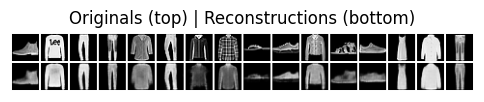

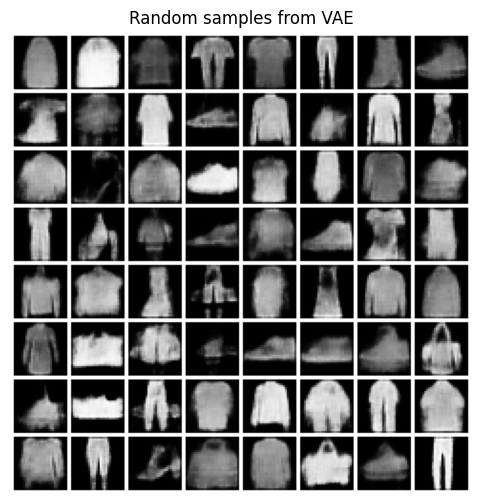

In [6]:
# Cell 5 — Show reconstructions & random samples
# Load a validation batch (reuse fixed_batch)
model.eval()
with torch.no_grad():
    x = fixed_batch
    x_rec, _, _ = model(x)

# show original vs recon
show_grid(torch.cat([x[:16].cpu(), x_rec[:16].cpu()], dim=0), nrow=16, title='Originals (top) | Reconstructions (bottom)')

# show random samples
with torch.no_grad():
    gen = model.sample(64, device=DEVICE)
show_grid(gen.cpu(), nrow=8, title='Random samples from VAE')


## **Latent Space Visualization**

Collect latents:   0%|          | 0/40 [00:00<?, ?it/s]

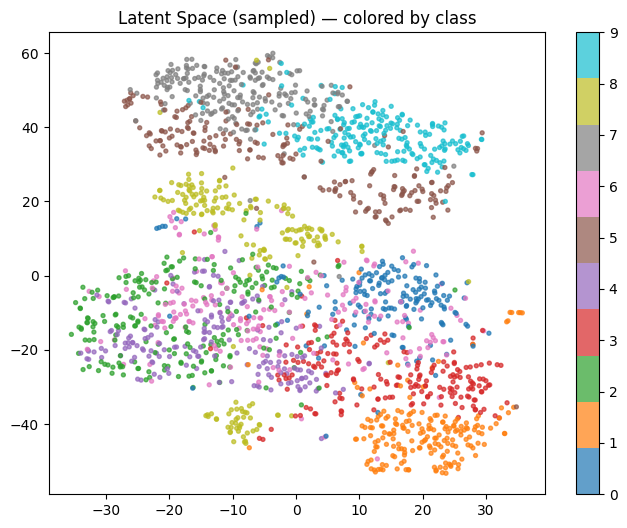

In [7]:
# Cell 6 — Latent-space visualization (TSNE on downsample)
# Collect latents for validation set
model.eval()
latents = []
labels = []
with torch.no_grad():
    for x, y in tqdm(val_loader, desc="Collect latents"):
        x = x.to(DEVICE)
        mu, logvar = model.encode(x)
        z = model.reparameterize(mu, logvar)
        latents.append(z.cpu())
        labels.append(y)

latents = torch.cat(latents).numpy()     # shape (N, latent_dim)
labels = torch.cat(labels).numpy()

# Downsample for speed
import numpy as np
max_pts = 2000
n = latents.shape[0]
if n > max_pts:
    idx = np.random.choice(n, size=max_pts, replace=False)
    latents_sub = latents[idx]
    labels_sub = labels[idx]
else:
    latents_sub = latents
    labels_sub = labels

# Try TSNE (may be slower), fallback to PCA if very slow
try:
    z_2d = TSNE(n_components=2, init="random", random_state=seed).fit_transform(latents_sub)
except Exception as e:
    print("t-SNE failed or too slow; using PCA fallback:", e)
    z_2d = PCA(n_components=2).fit_transform(latents_sub)

plt.figure(figsize=(8,6))
sc = plt.scatter(z_2d[:,0], z_2d[:,1], c=labels_sub, cmap='tab10', alpha=0.7, s=8)
plt.colorbar(sc, ticks=range(10))
plt.title("Latent Space (sampled) — colored by class")
plt.show()


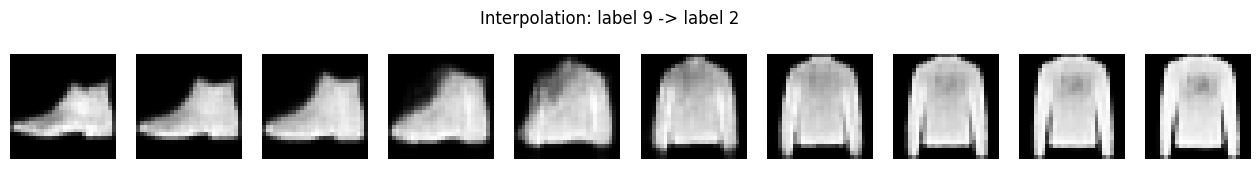

In [8]:
# Cell 7 — Latent interpolation helper + demo
def interpolate(img1, img2, steps=8):
    """Interpolate between two input images (shape 1xCxHxW) and return decoded images."""
    img1 = img1.to(DEVICE)
    img2 = img2.to(DEVICE)
    model.eval()
    with torch.no_grad():
        mu1, logvar1 = model.encode(img1)
        mu2, logvar2 = model.encode(img2)
        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)
        alphas = torch.linspace(0, 1, steps, device=DEVICE).unsqueeze(1)
        z_interp = (1 - alphas) * z1 + alphas * z2
        outs = model.decode(z_interp).cpu()
    return outs

# pick two images from validation set
images, labels = next(iter(val_loader))
img1 = images[0:1]
img2 = images[1:2]
outs = interpolate(img1, img2, steps=10)

plt.figure(figsize=(16,2))
for i in range(outs.shape[0]):
    plt.subplot(1, outs.shape[0], i+1)
    plt.imshow(outs[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle(f"Interpolation: label {labels[0].item()} -> label {labels[1].item()}")
plt.show()
